# 滴滴比赛 建模预测部分

预处理及可视化分析在其他部分

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandasql as pql
from datetime import datetime

from scipy.stats.stats import pearsonr

%matplotlib inline

In [2]:

# 训练集数据文件夹
base_dir = "G:/project/dataset/didi/season_1/training_data"

train_cluster_map_file = os.path.join(base_dir, 'cluster_map', 'cluster_map')

# 这个 POI 不打算使用
train_poi_file = os.path.join(base_dir, 'poi_data', 'poi_data')

# 训练集的 gap 中间文件
train_sd_gap_file = os.path.join(base_dir, 'sd_gap.csv')

# 训练集的 order 中间文件
train_order_file = os.path.join(base_dir, 'order_data', 'order_data.csv')

train_weather_file = os.path.join(base_dir, 'weather_data', 'weather_data.csv')

train_traffic_file = os.path.join(base_dir, 'traffic_data', 'traffic-data.csv')

# test data directory
test_base_dir = "G:/project/dataset/didi/season_1/test_set_1"

test_traffic_file = os.path.join(base_dir, 'traffic_data', 'traffic-data.csv')
test_order_file = os.path.join(test_base_dir, 'order_data', 'order-data.csv')

test_submit_file = os.path.join(test_base_dir, 'test.txt')

test_weather_file = os.path.join(test_base_dir, 'weather_data', 'weather_data.csv')

# 全部交通数据
all_traffic_file = os.path.join(base_dir, '..', 'all_traffic.csv')

sd_gap_file = os.path.join(base_dir, '..', 'gap.csv')

weather_file = os.path.join(test_base_dir, '..', 'weather_data.csv')

another_weather = os.path.join(test_base_dir, '..', 'weather.txt')
full_index_file = os.path.join(base_dir, '..', 'fullindex.csv')

full_file = os.path.join(base_dir, '..', 'full_data.csv')

# 提交文件
submit_file = os.path.join(test_base_dir, '..', 'submit.csv')
result_file = os.path.join(test_base_dir, '..', 'result.csv')


# 全体数据

id,Date,TimePiece,week,work,Weather,demand,supply,gap,traffic
区域 日期 时间片 需求 供应 缺口 星期（0-6对应周一到周天）

In [3]:
all_data_df = pd.read_csv(full_file, dtype = {'id': np.int16, 'TimePiece': np.int16, 'demand': np.double, 
                                                'supply': np.double, 'gap': np.double, 'week': np.int8, 
                                                 'work': np.bool, 'traffic': np.double, 'Weather': np.int8})
all_data_df[:5]

,id,Date,TimePiece,week,work,Weather,demand,supply,gap,traffic
0,1,2016-01-01,1,4,True,1,187,178,9,NaN
1,1,2016-01-01,2,4,True,1,198,191,7,0.140094
2,1,2016-01-01,3,4,True,1,192,182,10,0.120108
3,1,2016-01-01,4,4,True,1,172,167,5,0.122376
4,1,2016-01-01,5,4,True,1,153,152,1,0.114789


In [4]:
all_data_df.describe()

,id,TimePiece,week,work,Weather,demand,supply,gap,traffic
count,247104.00000,247104.000000,247104.000000,247104,247104.000000,171415.000000,171415.000000,171415.000000,201934.000000
mean,33.50000,72.500000,3.153846,0.692308,2.379274,53.079363,43.596908,9.482455,0.094944
std,19.05041,41.568301,1.974696,0.461539,1.928301,113.876910,82.040953,50.229963,0.043510
min,1.00000,1.000000,0.000000,False,0.000000,1.000000,0.000000,0.000000,0.000000
25%,17.00000,36.750000,1.000000,0,1.000000,4.000000,3.000000,0.000000,0.066667
50%,33.50000,72.500000,3.000000,1,2.000000,12.000000,10.000000,1.000000,0.093333
75%,50.00000,108.250000,5.000000,1,4.000000,48.000000,42.000000,4.000000,0.122040
max,66.00000,144.000000,6.000000,True,9.000000,4362.000000,1084.000000,3872.000000,1.000000


# 完整的索引

66个区域 * 21（21+5）天 * 144 个时间片， 完整数据要这样

有完整的， 才知道缺了哪些值， 才能填充—— 我目前想到的办法， 个人觉得比 在原dataframe 上一行行地添加数据来得快。

In [ ]:
full_df = pd.read_csv(full_index_file, dtype = {'id': np.int16, 'TimePiece': np.int16})
print len(full_df)

## 与已有供需数据合并

就会出现缺值位置 NaN

In [ ]:
full_data = full_df.merge(all_sd_df, on=['id', 'Date', 'TimePiece'], how='left')
full_data[:3]

In [ ]:
# 区域， 日期， 时间片三列都是 247104 行，  另外 四列有缺值。

full_data.describe()

# 过滤 元旦假期的 1,2,3号

其实感觉上， 4-7号也不是特别好， 观察 这几天下班高峰期几乎没有 供需缺口

In [4]:
train_data = all_data_df[(all_data_df.Date > '2016-01-03') & (all_data_df.Date < '2016-01-22')].loc[:, all_data_df.columns]

## 空缺值 进行 插值 补充

针对 

1. 需求 demand
2. 供应 supply

进行插值

插值方法应该有：

1. 缺失值 前后时间片的线性插值
2. 缺失值时间片 在历史其他日期 该时间片的平均值， 或同一星期的平均值 等

仅使用了第1条， 第2条未实现

In [5]:
train_data.demand = train_data.demand.interpolate()
train_data.supply = train_data.supply.interpolate()
train_data.gap = train_data.gap.interpolate()
train_data.traffic = train_data.traffic.interpolate()

In [6]:
train_data.traffic = train_data.traffic.fillna(method='bfill')
train_data.describe()

,id,TimePiece,week,work,Weather,demand,supply,gap,traffic
count,171072.000000,171072.000000,171072.000000,171072,171072.000000,171072.000000,171072.000000,171072.000000,171072.000000
mean,33.500000,72.500000,2.666667,0.777778,2.951775,43.732893,36.161926,7.570967,0.094868
std,19.050428,41.568339,1.943656,0.415741,1.797098,102.306479,76.045732,40.029699,0.043717
min,1.000000,1.000000,0.000000,False,0.000000,1.000000,0.000000,0.000000,0.000000
25%,17.000000,36.750000,1.000000,1,2.000000,2.000000,1.200000,0.000000,0.066551
50%,33.500000,72.500000,2.500000,1,3.000000,7.000000,6.000000,1.000000,0.093009
75%,50.000000,108.250000,4.000000,1,4.000000,32.000000,28.000000,3.000000,0.121949
max,66.000000,144.000000,6.000000,True,9.000000,1863.000000,902.000000,1341.000000,1.000000


## 缺失值补充后效果

### 按星期几分组， 查看同一组下， 各日期 的平均时间线

22 24 26 28 30 是待预测的日期， 缺失值使用插值补全

20号缺失若干时间片

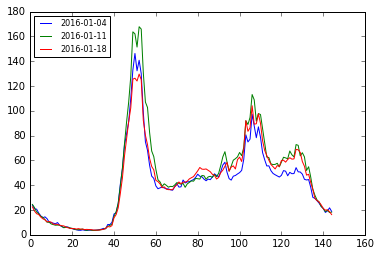

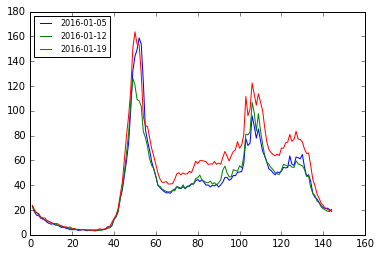

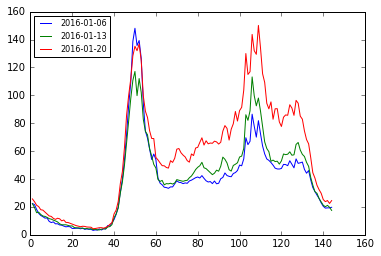

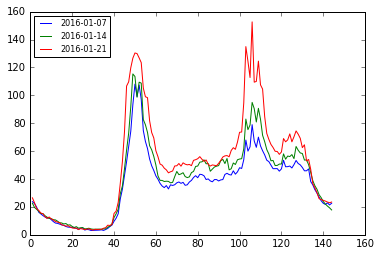

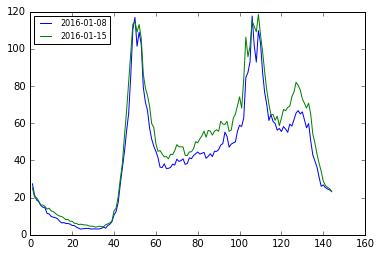

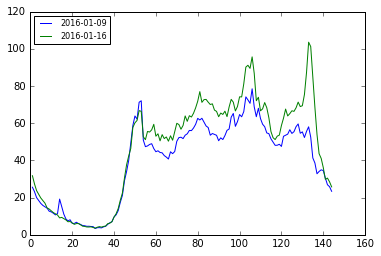

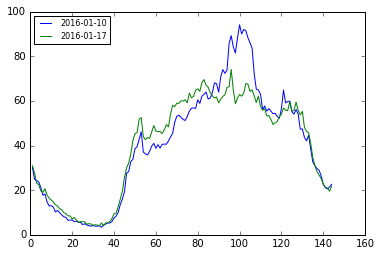

In [16]:
for week, wgr in train_data.groupby('week'):
    plt.figure()
    for date, dgr in wgr.groupby('Date'):
        plt.plot(dgr.groupby('TimePiece').demand.mean(), label=str(date))
    plt.legend(loc=2,prop={'size':8})

# 按星期、 时间片和区域分组， 求平均

因为目标是

区域， 日期-时间片， 缺口gap

使用同一星期的其他日期的平均值

In [ ]:
groupData = data.groupby(['week', 'TimePiece', 'id']).mean()
group_df = groupData.reset_index()

In [ ]:
group_df.describe()

In [ ]:
sort_df = group_df.sort_values('gap', ascending=False)

In [ ]:
sort_df[:5]

In [ ]:
tdf = all_sd_df[(all_sd_df.id == 51) & (all_sd_df.Date > '2016-01-02')]

In [ ]:

for date, dgrp in wgrp.groupby('Date'):
    plt.figure()
    plt.plot(dgrp.groupby('TimePiece').demand.mean(), label=date)
    plt.plot(dgrp.groupby('TimePiece').supply.mean())
    plt.plot(dgrp.groupby('TimePiece').gap.mean())
    plt.legend(loc=2)

# 提交文件的 indexfile

66个区域 * 5(22,24,26,28,30)天 * 每天若干个时间片

In [18]:
submit_df = pd.read_csv(submit_file, dtype={'id': np.int16, 'TimePiece': np.int16, 'week': np.int8})
len(submit_df)

2838

In [ ]:
(submit_df.Date + submit_df.TimePiece.map(str)).unique()

In [ ]:
result = submit_df.merge(group_df, on = ['week', 'TimePiece', 'id'], how='left')
result['DateT'] = result.Date + '-' + result.TimePiece.map(str)
result_df = result.loc[:, ['id', 'DateT', 'gap']]

In [ ]:
result.describe()

## 发现bug， 有缺失值

In [ ]:
resultnull = result[result.gap.isnull()]
resultnull.id.unique()

In [ ]:
resultnull[:4]

In [ ]:
resultnull.describe()

## 预测供需之差 和 预测缺口 似乎真没区别

In [ ]:
sum((result.demand - result.supply - result.gap).abs() > 0.01)

# 22到30号目标值

但只有几个时间片的值 ， 没有和其他时间片的合并。

In [ ]:
#for week, wgr in result.groupby('week'):
for date, dgr in result.groupby('Date'):
    plt.plot(dgr.groupby('TimePiece').demand.mean(), label=str(date))
plt.legend()

# 框架

用某些方法， 对数据进行训练等

In [7]:
from sklearn import tree, linear_model

In [8]:
def df_2_x(df, attrs):

    X = []

    #print df
    if len(df) != 3:
        return []

    temp = df.loc[:, attrs].values.reshape((1, 3 * len(attrs)))
    X.append(list(temp[0]))

    return X

In [9]:
def df_2_xy(df, attrs):
    tp = df.TimePiece.max()
    X = []
    y = []
    for date in df.Date.unique():
        
        subset = df[df.Date == date]
        #print date, len(subset)
        #print subset
        
        if len(subset) != 4:
            continue
        
        temp = subset[subset.TimePiece != tp].loc[:, attrs].values.reshape((1, 3 * len(attrs)))
        X.append(list(temp[0]))
        y.append(subset[subset.TimePiece == tp].loc[:, attrs].values[0][0])
        #print len(X[-1]), len(y[-1])
        #assert len(X[-1]) == 1 and len(y[-1]) == 1
    #print len(X), len(y)
    assert len(X) == len(y)
    return X, y

In [24]:

def train(train_df, test_df, full_df, r):
    
    # 遍历测试集要测试的时间片
    # 取时间片 范围[t-3, t-1]的训练数据， 训练一个回归方法。
    # 训练方法可以自由切换
    result = 1
    full_results = 1
    
    #clf = tree.DecisionTreeRegressor()
    clf = linear_model.LinearRegression()
    #full_clf = tree.DecisionTreeRegressor()

    region = r.id
    date = r.Date
    tp = r.TimePiece
    work = r.work

    #print tp

    # 时间片范围
    time_df = train_df[(train_df.TimePiece > int(tp) - 4) & (train_df.TimePiece <= int(tp)) & (train_df.work == work)]
    #cmp_df = full_df[(full_df.TimePiece > int(tp) - 4) & (full_df.TimePiece <= int(tp)) & (full_df.work == work)]

    time_test_df = test_df[(test_df.TimePiece > int(tp) - 4) & (test_df.TimePiece < int(tp)) & (test_df.Date == date)]

    #for region in range(1, 67):
        #print region

    region_df = time_df[time_df.id == region]
    #another_df = cmp_df[cmp_df.id == region]

    region_test_df = time_test_df[time_test_df.id == region]

    #print len(region_df), len(region_test_df)
    origin_x, origin_y = df_2_xy(region_df, ['gap', 'Weather', 'traffic'])
    #print 'sep'
    #full_x, full_y = df_2_xy(another_df, ['gap'])

    test_x = df_2_x(region_test_df, ['gap', 'Weather', 'traffic'])
    print region, date, tp
    
    #print len(origin_x), len(test_x)
    if not len(test_x):
        return 1

    #full_clf = full_clf.fit(origin_x, origin_y)
    #full_prd = full_clf.predict(test_x)
    #full_results.append(full_prd[0])

    if not len(origin_x):
        return 1
        
    #print origin_x, origin_y
    #print test_x, test_y

    clf = clf.fit(origin_x, origin_y)
    prd = int(clf.predict(test_x))
    return  prd if prd < 1 else prd

    #print results, full_results
    #print len(results)
    #target_df['prd_gap'] = pd.Series([e for e in results])
#
    #return target_df

In [ ]:
sampled_df = data.sample(100)
sampled_df = sampled_df.loc[:, ['id', 'Date', 'TimePiece', 'gap', 'week', 'work']]
result_df = sampled_df.loc[:, ['id', 'Date', 'TimePiece', 'gap', 'week', 'work']]

In [6]:
test_data = all_data_df[all_data_df.Date > '2016-01-21'].loc[:, all_data_df.columns]

In [19]:
test_data.traffic = test_data.traffic.interpolate()

In [20]:
test_data.describe()

,id,TimePiece,week,work,Weather,demand,supply,gap,traffic
count,47520.000000,47520.000000,47520.000000,47520,47520.000000,7924.000000,7924.000000,7924.000000,4.747800e+04
mean,33.500000,72.500000,3.800000,0.6,0.297222,70.417087,56.664563,13.752524,9.391496e-02
std,19.050572,41.568654,1.720483,0.489903,1.018175,140.675716,99.612180,57.930333,3.657202e-02
min,1.000000,1.000000,1.000000,False,0.000000,1.000000,0.000000,0.000000,4.625929e-17
25%,17.000000,36.750000,3.000000,0,0.000000,5.000000,4.000000,0.000000,6.958840e-02
50%,33.500000,72.500000,4.000000,1,0.000000,16.000000,14.000000,1.000000,9.135819e-02
75%,50.000000,108.250000,5.000000,1,0.000000,70.000000,61.000000,5.000000,1.173037e-01
max,66.000000,144.000000,6.000000,True,9.000000,1878.000000,783.000000,1164.000000,2.673305e-01


In [32]:
test_data[test_data.gap.notnull()].TimePiece.unique()

array([ 43,  44,  45,  55,  56,  57,  67,  68,  69,  79,  80,  81,  91,
        92,  93, 103, 104, 105, 115, 116, 117, 127, 128, 129, 139, 140, 141], dtype=int64)

In [7]:
def evaluate_mape(df):
    temp = df.apply(lambda s: 1.0 * abs(s['gap'] - s['prd_gap']) / s['gap'] if s['gap'] > 0 else 0, axis=1)
    return temp.mean()

def evaluate_gap(df):
    return (df['gap'] - df['prd_gap']).abs().sum()

def predict_evaluate():
    sampled_df = all_data_df[all_data_df.gap.notnull() & all_data_df.Weather.notnull() & all_data_df.traffic.notnull()]
    
    #sampled_df = sampled_df.loc[:, ['id', 'Date', 'TimePiece', 'gap', 'week', 'work']]
    result_df = sampled_df.sample(2838).loc[:, ['id', 'Date', 'TimePiece', 'gap', 'week', 'work']]

    import time
    start = time.time()
    result_df['prd_gap'] = pd.DataFrame({'prd_gap': 
                                         result_df.apply(lambda s: 
                                                         train(sampled_df, train_data, train_data, s), axis=1)})
    
    print 'mape', evaluate_mape(result_df)
    print 'gap', evaluate_gap(result_df)
    print 'time', time.time() - start

In [48]:
predict_evaluate()

mape 0.33768147383
gap 9716.0
time 226.83100009


In [49]:
predict_evaluate()

mape 0.329290598277
gap 11968.0
time 234.122999907


In [50]:
for i in range(3):
    predict_evaluate()

mape 0.323201792965
gap 10102.0
time 237.588000059
mape 0.329768262019
gap 9497.0
time 235.883999825
mape 0.300288349121
gap 9057.0
time 232.264999866


In [ ]:
import time
start = time.time()
result_df['prd_gap'] = pd.DataFrame({'prd_gap': result_df.apply(lambda s: train(data, data, temp, s), axis=1)})
print time.time() - start

In [ ]:
evaluate_mape(result_df)

In [ ]:
evaluate_gap(result_df)

In [ ]:
result_df.describe()

## 从日期时间片df处理csv文件

In [ ]:
def resultCsv(result):
    result['DateT'] = result.Date + '-' + result.TimePiece.map(str)
    result_df = result.loc[:, ['id', 'DateT', 'gap']]
    result_df.to_csv(result_file, index=False, header=False)

In [ ]:
# resultCsv(result_df)

# 重新读取提交文件， 处理小数的gap

In [ ]:
test_df = data[data.Date > '2016-01-21']
print len(test_df)

In [ ]:
test_df.groupby('TimePiece').count()

In [4]:
result_df = pd.read_csv(result_file, dtype={'id': np.int16, 'gap': np.int32}, names = ['id','DateT', 'gap'])

In [16]:
result_df.describe()

,id,gap,TimePiece,week,work
count,2838.000000,2838.000000,2838.000000,2838.000000,2838
mean,33.500000,12.483087,96.232558,3.767442,0.604651
std,19.053729,58.306444,29.880071,1.723432,0.489012
min,1.000000,0.000000,46.000000,1.000000,False
25%,17.000000,0.000000,70.000000,3.000000,0
50%,33.500000,1.000000,94.000000,4.000000,1
75%,50.000000,4.000000,118.000000,5.000000,1
max,66.000000,1109.000000,142.000000,6.000000,True


In [ ]:
result_df[:5]

In [5]:
result_df['Date'] = pd.Series(['-'.join(e.split('-')[:-1]) for e in result_df.DateT])
result_df['TimePiece'] = pd.Series([int(e.split('-')[-1]) for e in result_df.DateT])
result_df['week'] = pd.Series([datetime.strptime(e, "%Y-%m-%d").weekday() for e in result_df.Date])
result_df['work'] = pd.Series([e < 5 for e in result_df.week])

In [ ]:
import time
start = time.time()
result_df['prd_gap'] = pd.DataFrame({'prd_gap': result_df.apply(lambda s: train(train_data, test_data, train_data, s), axis=1)})
print time.time() - start

In [27]:
def weight_avg(data, r):
    
    region = r.id
    date = r.Date
    tp = r.TimePiece
    work = r.work

    map_df = data[(data.TimePiece > int(tp) - 4) & (data.TimePiece < int(tp)) & (data.Date == date) & (data.id == region)]

    print len(map_df),
    p1 = map_df[map_df.TimePiece == int(tp)-3].gap.values[0]
    if np.isnan(p1):
        p1 = 0
    
    p2 = map_df[map_df.TimePiece == int(tp)-2].gap.values[0]
    if np.isnan(p2):
        p2 = 0
    p3 = map_df[map_df.TimePiece == int(tp)-1].gap.values[0]
    if np.isnan(p3):
        p3 = 0
    
    p = max(1,int((p1 * 0.65 + p2 * 0.25 + p3 * 0.15)/2))
    print p
    return p        

In [28]:
import time
start = time.time()
result_df['prd_gap'] = pd.DataFrame({'prd_gap': result_df.apply(lambda s: weight_avg(test_data, s), axis=1)})
print time.time() - start

3 1
3 1
3 1
3 1
3 2
3 4
3 2
3 5
3 3
3 2
3 3
3 4
3 1
3 3
3 2
3 2
3 2
3 1
3 2
3 2
3 2
3 2
3 4
3 2
3 4
3 2
3 4
3 2
3 3
3 2
3 5
3 2
3 5
3 4
3 6
3 2
3 1
3 3
3 2
3 4
3 4
3 2
3 4
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 2
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 43
3 4
3 20
3 5
3 2
3 11
3 5
3 1
3 4
3 3
3 6
3 2
3 1
3 1
3 3
3 1
3 1
3 33
3 4
3 6
3 1
3 1
3 1
3 4
3 1
3 36
3 1
3 3
3 3
3 2
3 7
3 5
3 1
3 5
3 1
3 4
3 4
3 3
3 1
3 2
3 4
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 2
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 2
3 1
3 1
3 1
3 1
3 1
3 2
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 15
3 3
3 7
3 1
3 1
3 1
3 1
3 1
3 2
3 2
3 2
3 1
3 1
3 1
3 1
3 1
3 1
3 12
3 3
3 1
3 1
3 1
3 1
3 1
3 1
3 10
3 1
3 1
3 1
3 1
3 1
3 1


In [30]:
test_data.gap = test_data.gap.fillna(method='bfill')
test_data[(test_data.id == 3) & (test_data.Date == '2016-01-22') & (test_data.TimePiece > 90)]

,id,Date,TimePiece,week,work,Weather,demand,supply,gap,traffic
199962,3,2016-01-22,91,4,True,0,1,1,0,0.091575
199963,3,2016-01-22,92,4,True,4,NaN,NaN,1,0.089239
199964,3,2016-01-22,93,4,True,0,3,2,1,0.094923
199965,3,2016-01-22,94,4,True,0,NaN,NaN,2,0.094531
199966,3,2016-01-22,95,4,True,0,NaN,NaN,2,0.094140
199967,3,2016-01-22,96,4,True,0,NaN,NaN,2,0.093749
199968,3,2016-01-22,97,4,True,0,NaN,NaN,2,0.093357
199969,3,2016-01-22,98,4,True,0,NaN,NaN,2,0.092966
199970,3,2016-01-22,99,4,True,0,NaN,NaN,2,0.092574
199971,3,2016-01-22,100,4,True,0,NaN,NaN,2,0.092183


In [ ]:
result_df.gap = pd.Series([int(e) if e > 1.01 else 1 for e in result_df.gap])

In [29]:
evaluate_gap(result_df)

21903L

In [30]:
evaluate_mape(result_df)

0.3133001218190987

In [34]:
result_df.describe()

,id,gap,TimePiece,week,work,prd_gap
count,2838.000000,2838.000000,2838.000000,2838.000000,2838,2.838000e+03
mean,33.500000,12.483087,96.232558,3.767442,0.604651,1.756787e+11
std,19.053729,58.306444,29.880071,1.723432,0.489012,5.835669e+12
min,1.000000,0.000000,46.000000,1.000000,False,-2.100000e+02
25%,17.000000,0.000000,70.000000,3.000000,0,0.000000e+00
50%,33.500000,1.000000,94.000000,4.000000,1,1.000000e+00
75%,50.000000,4.000000,118.000000,5.000000,1,5.000000e+00
max,66.000000,1109.000000,142.000000,6.000000,True,2.494704e+14


In [ ]:
result_df.loc[:, ['id', 'DateT', 'prd_gap']].to_csv(result_file, index=False, header=False)

In [ ]:
result_df['prd_gap'] = pd.Series([ e if e > 10 else 1 for e in result_df.gap])

In [31]:
temp_df = result_df.loc[:, ['id', 'DateT', 'prd_gap']]
temp_df.to_csv(result_file, index=False, header=False)

In [32]:
temp_df.describe()

,id,prd_gap
count,2838.000000,2838.000000
mean,33.500000,6.866103
std,19.053729,29.352363
min,1.000000,1.000000
25%,17.000000,1.000000
50%,33.500000,1.000000
75%,50.000000,2.000000
max,66.000000,526.000000


# 模型评估

    mape=function(district_id,timeslot,actual,pred){
      dt=data.table(district_id,timeslot,actual,pred)
      dt[,ape:=ifelse(actual==0,0,abs(pred-actual)/actual)]
      mean(dt[,mean(ape),by=.(district_id)]$V1)
    }
    
在同一 dataframe里gap 为实际值， prd_gap 为预测值

不同的模型评估策略的实现

In [ ]:
evaluate_mape(result_df)

In [ ]:
evaluate_gap(result_df)